In [ ]:
import os
import zipfile
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define Paths
zip_path = '/content/drive/MyDrive/augmented_pepper_dataset.zip'
extract_path = '/content/pepper_inspection'

# 3. Unzip the file
print(f"Unzipping {zip_path}...")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)
print("Unzip complete!\n")

# 4. Check what's inside (Recursive Directory View)
print("--- Dataset Structure ---")
for root, dirs, files in os.walk(extract_path):
    # This calculates the depth to make the print look like a tree
    level = root.replace(extract_path, '').count(os.sep)
    indent = ' ' * 4 * (level)
    print(f"{indent}{os.path.basename(root)}/")

    # Optional: Print first 2 files in each folder to verify content
    sub_indent = ' ' * 4 * (level + 1)
    for f in files[:2]:
        print(f"{sub_indent}{f}")
    if len(files) > 2:
        print(f"{sub_indent}... ({len(files)} total files)")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Unzipping /content/drive/MyDrive/augmented_pepper_dataset.zip...
Unzip complete!

--- Dataset Structure ---
pepper_inspection/
    content/
        dataset/
            UNHEALTHY/
                Slow-Decline/
                    IMG_20241226_171955.jpeg
                    IMG_20250315_123042.jpeg.jpeg.jpeg.jpeg
                    ... (500 total files)
                augmented/
                    IMG_20250315_113118.jpeg__crop.jpeg
                    PYMV059__poisson_noise.jpg
                    ... (32736 total files)
                black_pepper_yellow_mottle_virus/
                    PYMV080.jpg
                    PYMV211.jpg
                    ... (273 total files)
                Pollu_Disease/
                    IMG_20250311_160634.jpeg
                    IMG_20250131_161214.jpeg
                    ... (500 total files)
                MERGE

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from tqdm import tqdm
import os
from PIL import Image
from google.colab import drive

# 1. Mount Drive
drive.mount('/content/drive')

# 2. Path Configuration
# These are based on your specific unzipped directory structure
healthy_path = '/content/pepper_inspection/content/dataset/HEALTHY/augmented'
unhealthy_path = '/content/pepper_inspection/content/dataset/UNHEALTHY/augmented'
save_path = '/content/drive/MyDrive/best_pepper_squeezenet.pth'

# 3. Custom Dataset Class to handle the massive file count
class PepperDataset(Dataset):
    def __init__(self, healthy_dir, unhealthy_dir, transform=None):
        self.transform = transform
        self.images = []

        # Load Healthy images (Label 0)
        for f in os.listdir(healthy_dir):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                self.images.append((os.path.join(healthy_dir, f), 0))

        # Load Unhealthy images (Label 1)
        for f in os.listdir(unhealthy_dir):
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                self.images.append((os.path.join(unhealthy_dir, f), 1))

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

# 4. Transforms & Loading
# Keeping your 500x500 resolution from ResNet18
data_transforms = transforms.Compose([
    transforms.Resize((500, 500)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = PepperDataset(healthy_path, unhealthy_path, transform=data_transforms)

# Split 80/20
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = random_split(full_dataset, [train_size, val_size])

# SqueezeNet is lightweight, so we can use a slightly higher batch size than 8
train_loader = DataLoader(train_set, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_set, batch_size=16, shuffle=False, num_workers=2)

# 5. Model Initialization (SqueezeNet PLC-SN)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = models.squeezenet1_1(weights='IMAGENET1K_V1')
# Adjusting classifier for 2 classes (Healthy vs Unhealthy)
model.classifier[1] = nn.Conv2d(512, 2, kernel_size=(1,1))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)

# 6. Training Function
def train_model(epochs=10):
    best_acc = 0.0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0

        # Training Progress Bar
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs}', unit='batch')

        for inputs, labels in pbar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

            # Show live batch accuracy
            pbar.set_postfix(loss=f"{loss.item():.4f}", acc=f"{torch.sum(preds == labels.data).item()/inputs.size(0):.4f}")

        # Validation Phase
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        epoch_acc = val_corrects.double() / val_size
        print(f"\nEpoch {epoch+1} Validation Accuracy: {epoch_acc:.4f}")

        # Save Best Weights to Drive
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            torch.save(model.state_dict(), save_path)
            print(f"🌟 Best model saved to Drive! (Acc: {best_acc:.4f})")

# 7. Start Training
train_model(epochs=10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda
Downloading: "https://download.pytorch.org/models/squeezenet1_1-b8a52dc0.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_1-b8a52dc0.pth


100%|██████████| 4.73M/4.73M [00:00<00:00, 192MB/s]
Epoch 1/10: 100%|██████████| 2398/2398 [07:13<00:00,  5.53batch/s, acc=1.0000, loss=0.0324]



Epoch 1 Validation Accuracy: 0.9970
🌟 Best model saved to Drive! (Acc: 0.9970)


Epoch 2/10: 100%|██████████| 2398/2398 [07:09<00:00,  5.58batch/s, acc=1.0000, loss=0.0001]



Epoch 2 Validation Accuracy: 0.9980
🌟 Best model saved to Drive! (Acc: 0.9980)


Epoch 3/10: 100%|██████████| 2398/2398 [07:03<00:00,  5.66batch/s, acc=1.0000, loss=0.0002]



Epoch 3 Validation Accuracy: 0.9638


Epoch 4/10: 100%|██████████| 2398/2398 [06:54<00:00,  5.78batch/s, acc=1.0000, loss=0.0001]



Epoch 4 Validation Accuracy: 0.9993
🌟 Best model saved to Drive! (Acc: 0.9993)


Epoch 5/10: 100%|██████████| 2398/2398 [06:53<00:00,  5.80batch/s, acc=1.0000, loss=0.0000]



Epoch 5 Validation Accuracy: 0.9948


Epoch 6/10: 100%|██████████| 2398/2398 [06:59<00:00,  5.72batch/s, acc=1.0000, loss=0.0002]



Epoch 6 Validation Accuracy: 0.9990


Epoch 7/10: 100%|██████████| 2398/2398 [06:57<00:00,  5.74batch/s, acc=1.0000, loss=0.0000]



Epoch 7 Validation Accuracy: 0.9995
🌟 Best model saved to Drive! (Acc: 0.9995)


Epoch 8/10: 100%|██████████| 2398/2398 [06:59<00:00,  5.72batch/s, acc=1.0000, loss=0.0000]



Epoch 8 Validation Accuracy: 0.9998
🌟 Best model saved to Drive! (Acc: 0.9998)


Epoch 9/10: 100%|██████████| 2398/2398 [06:54<00:00,  5.78batch/s, acc=1.0000, loss=0.0003]



Epoch 9 Validation Accuracy: 0.9997


Epoch 10/10: 100%|██████████| 2398/2398 [06:59<00:00,  5.72batch/s, acc=1.0000, loss=0.0000]



Epoch 10 Validation Accuracy: 0.9998


Upload your pepper plant image:


Saving test3.png to test3 (2).png

0: 640x480 (no detections), 9.4ms
Speed: 2.1ms preprocess, 9.4ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)


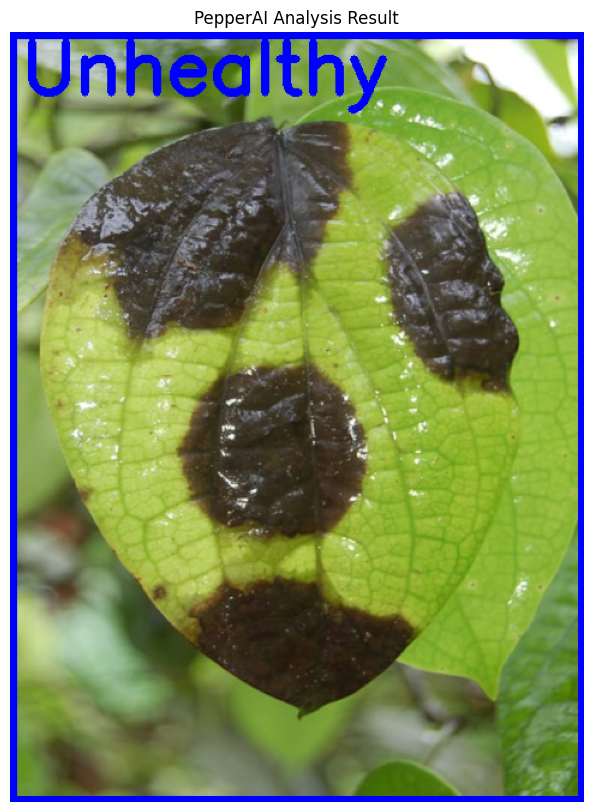

In [19]:
# 1. Install necessary library
#!pip install ultralytics

import cv2
import torch
import torch.nn as nn
from ultralytics import YOLO
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
from google.colab import files

# --- STEP 1: LOAD YOUR TRAINED CLASSIFIER ---
def load_pepper_model(model_path):
    # Initialize SqueezeNet 1.1 architecture first to avoid OrderedDict error
    model = models.squeezenet1_1(weights=None)

    # Adjust final layer to match your 2 classes
    num_classes = 2
    model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1))

    # Load the weights (state_dict)
    state_dict = torch.load(model_path, map_location=torch.device('cpu'))
    model.load_state_dict(state_dict)
    model.eval()
    return model

# --- STEP 2: SETUP PREPROCESSING ---
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load models (Replace path with your actual Google Drive path)
# The detector is used for finding leaves in a large plant photo
detector = YOLO('yolov8n.pt')
classifier = load_pepper_model('/content/drive/MyDrive/best_pepper_squeezenet.pth')
class_names = ['Healthy', 'Unhealthy']

# --- STEP 3: ANALYSIS FUNCTION WITH FALLBACK ---
def run_pepper_analysis(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    results = detector(img_rgb)
    detections_found = False

    # Iterate through YOLO detections
    for result in results:
        if len(result.boxes) > 0:
            detections_found = True
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])
                process_and_draw(img, img_rgb, x1, y1, x2, y2)

    # FALLBACK: If YOLO finds nothing, treat the whole image as one leaf
    if not detections_found:
        h, w, _ = img.shape
        process_and_draw(img, img_rgb, 0, 0, w, h)

    plt.figure(figsize=(10, 10))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title("PepperAI Analysis Result")
    plt.show()

def process_and_draw(img, img_rgb, x1, y1, x2, y2):
    crop = img_rgb[y1:y2, x1:x2]
    if crop.size == 0: return

    pil_img = Image.fromarray(crop)
    input_tensor = preprocess(pil_img).unsqueeze(0)

    with torch.no_grad():
        output = classifier(input_tensor)
        index = torch.argmax(output, dim=1).item()
        label = class_names[index]

    color = (0, 255, 0) if label == 'Healthy' else (255, 0, 0)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 10)
    cv2.putText(img, label, (x1 + 10, y1 + 50), cv2.FONT_HERSHEY_SIMPLEX, 2, color, 5)

# --- STEP 4: START TESTING ---
print("Upload your pepper plant image:")
uploaded = files.upload()

for filename in uploaded.keys():
    run_pepper_analysis(filename)